# Xây dựng và tối ưu mô hình ARIMA dự báo số lượng hàng bán được trong 6 tháng tới

## Lý thuyết

Mô hình ARIMA (AutoRegressive Integrated Moving Average) là một trong những mô hình phổ biến trong phân tích chuỗi thời gian. Nó bao gồm ba thành phần chính: AutoRegressive (AR), Integrated (I), và Moving Average (MA). Cụ thể, mô hình ARIMA được ký hiệu là ARIMA(p, d, q), trong đó:

- **AR (AutoRegressive)**: Thành phần tự hồi quy. Đây là thành phần sử dụng các giá trị trước đó của chính chuỗi thời gian để dự đoán giá trị hiện tại. Số lượng giá trị trước đó được sử dụng gọi là `p`.
- **I (Integrated)**: Thành phần tích hợp. Đây là số lần lấy sai phân của chuỗi thời gian để làm cho chuỗi trở nên tĩnh (stationary). Một chuỗi tĩnh có nghĩa là các thống kê của chuỗi không thay đổi theo thời gian. Số lần lấy sai phân được gọi là `d`.
- **MA (Moving Average)**: Thành phần trung bình động. Đây là thành phần sử dụng các giá trị lỗi dự đoán (residuals) trước đó để dự đoán giá trị hiện tại. Số lượng giá trị lỗi trước đó được sử dụng gọi là `q`.

**Giải thích chi tiết hơn về các tham số (p, d, q):**

1. **p (số lượng giá trị tự hồi quy)**:
   - Nếu p=0, mô hình không có thành phần tự hồi quy.
   - Nếu p=1, mô hình sử dụng giá trị trước đó của chuỗi thời gian để dự đoán giá trị hiện tại.
   - Nếu p=2, mô hình sử dụng hai giá trị trước đó của chuỗi thời gian để dự đoán giá trị hiện tại, và cứ thế tiếp tục.

2. **d (số lần lấy sai phân để chuỗi trở nên tĩnh)**:
   - Nếu d=0, chuỗi đã là tĩnh.
   - Nếu d=1, chuỗi cần lấy sai phân một lần để trở nên tĩnh (xem xét sự thay đổi giữa các giá trị liên tiếp).
   - Nếu d=2, chuỗi cần lấy sai phân hai lần để trở nên tĩnh (xem xét sự thay đổi giữa các giá trị liên tiếp của sai phân lần đầu tiên).

3. **q (số lượng giá trị lỗi trung bình động)**:
   - Nếu q=0, mô hình không có thành phần trung bình động.
   - Nếu q=1, mô hình sử dụng giá trị lỗi dự đoán trước đó để dự đoán giá trị hiện tại.
   - Nếu q=2, mô hình sử dụng hai giá trị lỗi dự đoán trước đó để dự đoán giá trị hiện tại, và cứ thế tiếp tục.

**Ví dụ cụ thể:**
- **ARIMA(1,0,0)**: Mô hình chỉ có thành phần tự hồi quy với một giá trị trước đó, không cần lấy sai phân, không có thành phần trung bình động.
- **ARIMA(0,1,1)**: Mô hình cần lấy sai phân một lần để trở nên tĩnh, sử dụng một giá trị lỗi dự đoán trước đó để dự đoán giá trị hiện tại, không có thành phần tự hồi quy.
- **ARIMA(2,1,2)**: Mô hình cần lấy sai phân một lần để trở nên tĩnh, sử dụng hai giá trị trước đó của chuỗi và hai giá trị lỗi dự đoán trước đó để dự đoán giá trị hiện tại.

Trong thực tế, việc chọn bộ tham số (p, d, q) tốt nhất thường dựa trên việc thử nghiệm và đánh giá các mô hình khác nhau. Phương pháp thông dụng để xác định các tham số này bao gồm việc sử dụng biểu đồ tự hồi quy (ACF) và biểu đồ tự tương quan riêng phần (PACF), hoặc sử dụng phương pháp tìm kiếm lưới (grid search).

## Thực hành

In [1]:
# Importing
import pandas as pd
import numpy as np
# import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Chuẩn bị dữ liệu

In [2]:
dtype = {
    'customer_id': str,
    'gender_cd': str,
    'postal_cd': str,
    'application_store_cd': str,
    'status_cd': str,
    'category_major_cd': str,
    'category_medium_cd': str,
    'category_small_cd': str,
    'product_cd': str,
    'store_cd': str,
    'prefecture_cd': str,
    'tel_no': str,
    'postal_cd': str,
    'street': str
}

df_receipt = pd.read_csv("../../data/preprocessed/receipt.csv", dtype=dtype)

# Nhóm amount theo tháng và năm
df_ts_amount = (
    df_receipt[["sales_ymd", "amount"]]
    .assign(
        sales_ym=lambda df: df["sales_ymd"].astype("str").str[0:6]
    )
    .groupby("sales_ym").agg({"amount": "sum"})
    .reset_index()
)

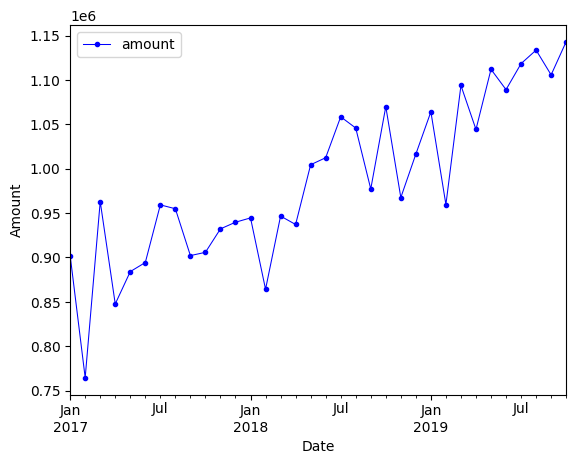

In [3]:
# Chuyển sales_ym thành index
data = df_ts_amount.copy()

data['sales_ym'] = pd.to_datetime(data['sales_ym'], format='%Y%m')
data.set_index('sales_ym', inplace=True)

# Trực quan hoá dữ liệu
fig, ax = plt.subplots()
data.plot(c="b", style=".-", lw=0.75, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Amount")
plt.show()

### Xây dựng mô hình ARIMA đơn giản

In [5]:
# Xây dựng mô hình ARIMA đơn giản
data = df_ts_amount.copy()

# Chuyển đổi cột sales_ym thành dạng datetime
data['sales_ym'] = pd.to_datetime(data['sales_ym'], format='%Y%m')
data.set_index('sales_ym', inplace=True)

# Sắp xếp dữ liệu theo thời gian
data = data.sort_index()

# Chia dữ liệu thành tập huấn luyện đến tháng 4/2019
train_data = data[:'2019-04']
test_data = data['2019-05':'2019-10']

# Xây dựng mô hình ARIMA
model = ARIMA(train_data['amount'], order=(5, 1, 0))  # (p,d,q) có thể thay đổi theo yêu cầu
model_fit = model.fit()

# Dự báo
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = test_data.index

# Đánh giá mô hình
mae = mean_absolute_error(test_data['amount'], forecast)
mse = mean_squared_error(test_data['amount'], forecast)
rmse = mse ** 0.5

# Hiển thị đánh giá mô hình
print(mae)
print(rmse)

42980.36405958453
46209.65902916089


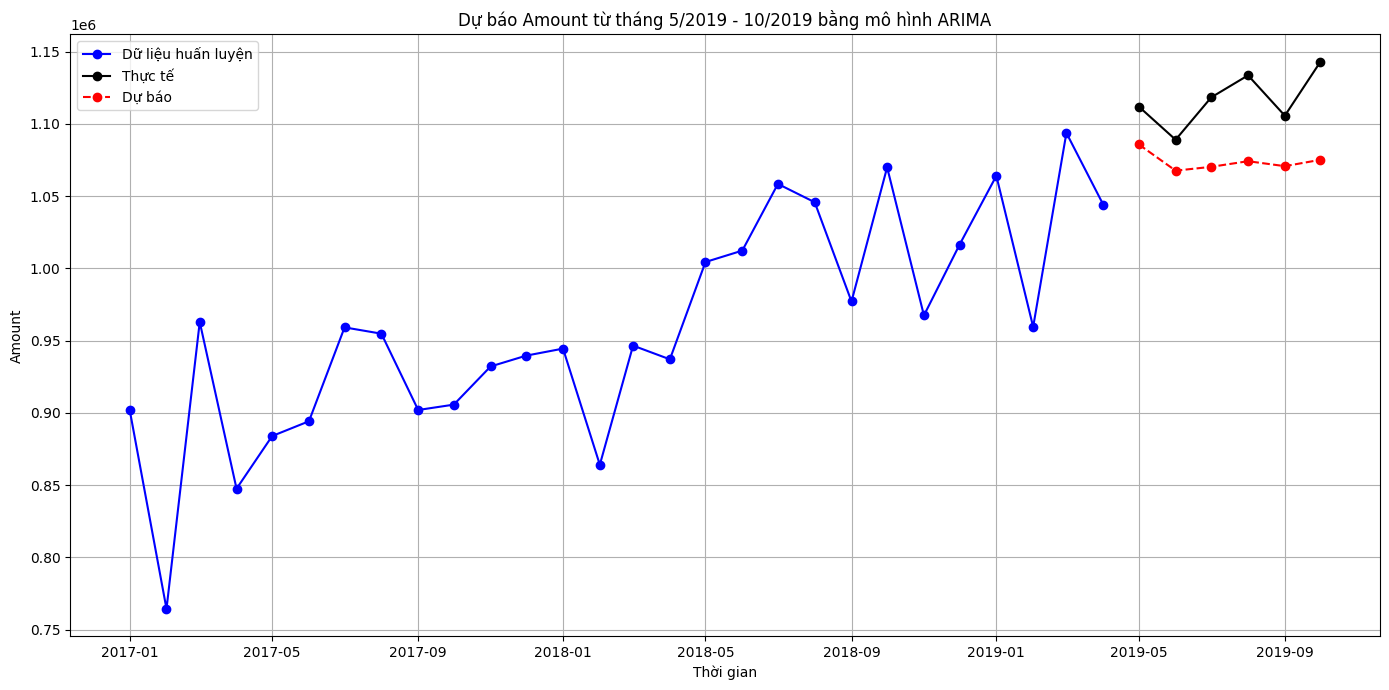

In [6]:
# Trực quan hóa kết quả dự báo
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['amount'], "bo-",label='Dữ liệu huấn luyện')
plt.plot(test_data.index, test_data['amount'], "ko-",label='Thực tế')
plt.plot(forecast_index, forecast, "ro--",label='Dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Amount')
plt.title('Dự báo Amount từ tháng 5/2019 - 10/2019 bằng mô hình ARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Tunning bộ tham số (p, d, q)

In [7]:
# Tunning bộ tham số (p, d, q)
import itertools

# Xác định bộ tham số (p, d, q) tốt nhất
p = range(0, 6)
d = range(0, 2)
q = range(0, 6)
pdq = list(itertools.product(p, d, q))

best_mae = float('inf')
best_pdq = None
best_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train_data['amount'], order=param)
        temp_model_fit = temp_model.fit()
        temp_forecast = temp_model_fit.forecast(steps=len(test_data))
        temp_mae = mean_absolute_error(test_data['amount'], temp_forecast)
        if temp_mae < best_mae:
            best_mae = temp_mae
            best_pdq = param
            best_model = temp_model_fit
    except:
        continue

# Dự báo với mô hình tốt nhất
forecast = best_model.forecast(steps=len(test_data))
forecast_index = test_data.index

# Đánh giá mô hình
mae = mean_absolute_error(test_data['amount'], forecast)
mse = mean_squared_error(test_data['amount'], forecast)
rmse = mse ** 0.5

# Hiển thị đánh giá mô hình
print(mae)
print(rmse)

17570.525963285472
19312.53555745487


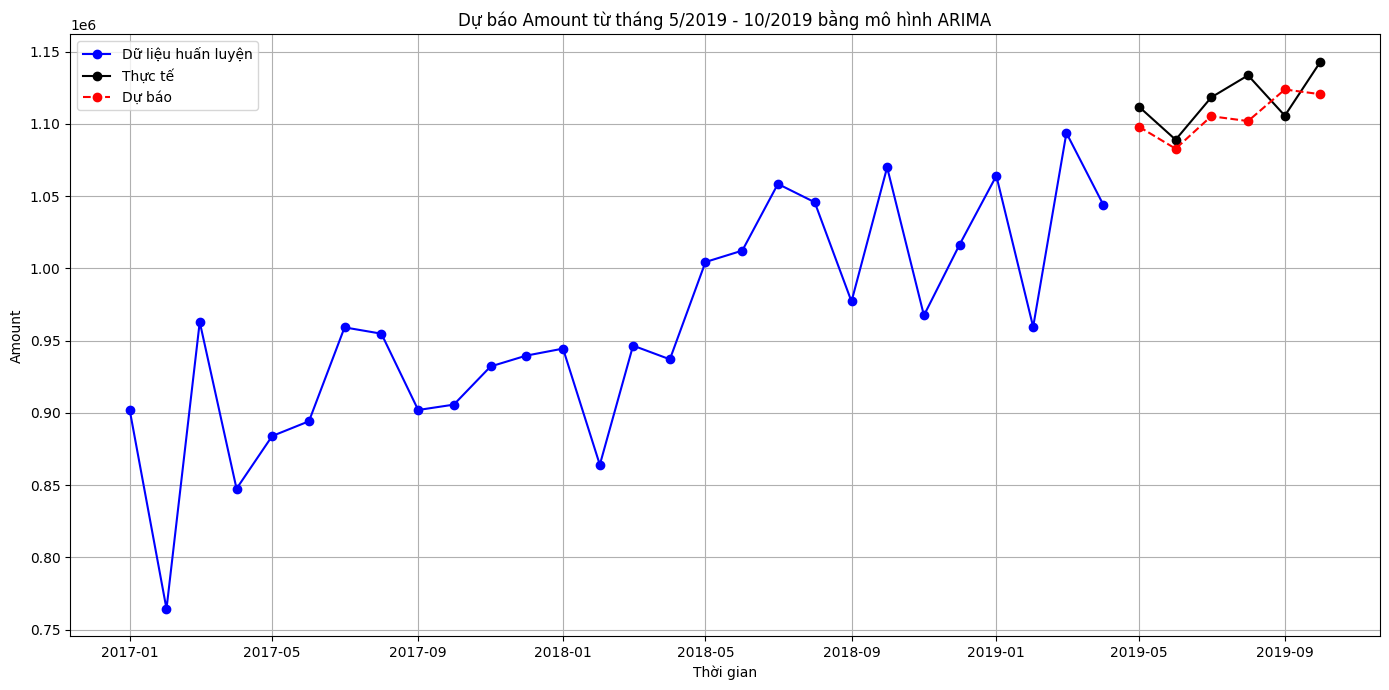

In [8]:
# Trực quan hóa kết quả dự báo
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['amount'], "bo-",label='Dữ liệu huấn luyện')
plt.plot(test_data.index, test_data['amount'], "ko-",label='Thực tế')
plt.plot(forecast_index, forecast, "ro--",label='Dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Amount')
plt.title('Dự báo Amount từ tháng 5/2019 - 10/2019 bằng mô hình ARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()